## 0. Set up

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
from upsetplot import UpSet, from_indicators

In [2]:
data_dir='/home/jovyan/data'

## 1. QC of 1000G VCF

Set file paths

In [116]:
gwd_prefix = 'GWD_30x_calls'

raw_ref = f'{data_dir}/{gwd_prefix}.vcf.gz'
variant_info = f'{data_dir}/{gwd_prefix}.variant_info.tsv'

qced_ref = f'{data_dir}/{gwd_prefix}.qced.vcf.gz'

split_ref = f'{data_dir}/{gwd_prefix}.split.vcf.gz'

phased_ref_prefix = f'{data_dir}/{gwd_prefix}.phased'
phased_ref = f'{phased_ref_prefix}.vcf.gz'

##### **(OPTIONAL)** Print fields from VCF

In [ ]:
%%bash -s "$data_dir"

data_dir=$1

bcftools view -h $data_dir/GWD_30x_calls.vcf.gz | grep "^##.*INFO\|^##FORMAT"

# NOTE
# QUAL - Phred-scaled quality score for the assertion made in ALT. 
# See https://samtools.github.io/hts-specs/VCFv4.1.pdf

#### 1.1 Extract fields from VCF, save as table

In [117]:
%%bash -s "$data_dir" "$raw_ref" "$variant_info"

data_dir=$1
raw_ref=$2
variant_info=$3

bcftools query -f '%POS\t%DP\t%QUAL\t%VDB\t%SGB\t%RPB\t%MQB\t%MQSB\t%BQB\t%MQ0F\t%AC\t%AN\t%MQ\n' ${raw_ref} > ${variant_info}

#### 1.2 Plot fields

In [118]:
info = pd.read_csv(
    variant_info, 
    sep='\t', 
    names=['pos','dp','qual','vdb','sgb','rpb','mqb','mqsb','bqb','mq0f','ac', 'an','mq'],
    na_values=['.']
)

In [119]:
field_title_dict = {
    'dp': 'Raw read depth',
    'qual': 'Phred-scaled quality score for the assertion made in ALT',
    'vdb': 'Variant Distance Bias for filtering splice-site artefacts in RNA-seq data\n(bigger is better)',
    'rpb': 'Mann-Whitney U test of Read Position Bias\n(bigger is better)',
    'mqb': 'Mann-Whitney U test of Mapping Quality Bias\n(bigger is better)',
    'bqb': 'Mann-Whitney U test of Base Quality Bias\n(bigger is better)',
    'mqsb': 'Mann-Whitney U test of Mapping Quality vs Strand Bias\n(bigger is better)',
    'sgb': 'Segregation based metric',
    'mq0f': 'Fraction of MQ0 reads\n(smaller is better)',
    'ac': 'Allele count in genotypes for each ALT allele, in the same order as listed',
    'an': 'Total number of alleles in called genotypes',
    'mq': 'Average mapping quality'
}

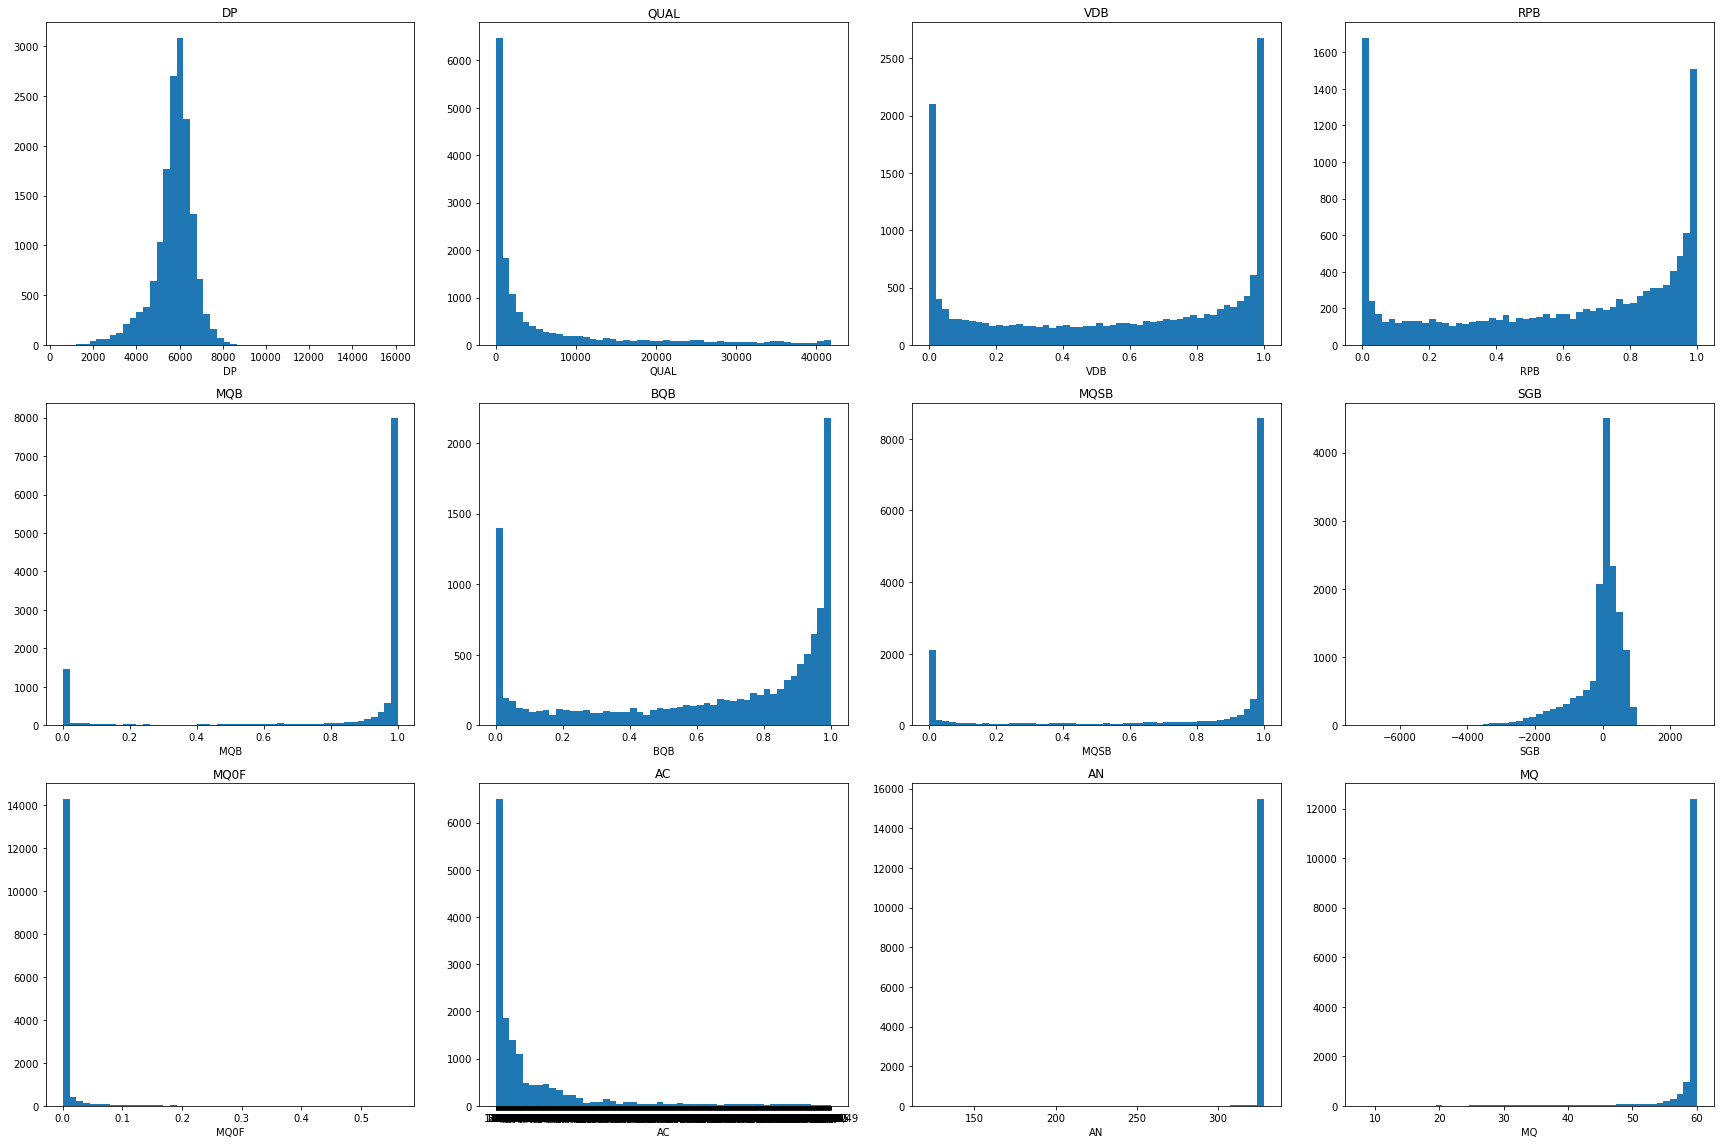

In [44]:
fig, axs = plt.subplots(figsize=(24,16), nrows=3, ncols=4)

for i, f in enumerate(field_title_dict.keys()):
    _ = axs[i//4,i%4].hist(info[f], 50)
    _ = axs[i//4,i%4].set_xlabel(f.upper())
    axs[i//4,i%4].set_title(f.upper())

plt.tight_layout()

plt.savefig('/home/jovyan/plots/GWD_30x_calls.vcf.variant_info.png',dpi=300)

#### 1.3 Set cutoffs

In [75]:
include_variants_dict = {
    'dp': ('>', 1000), #'Raw read depth'
    'qual': ('>', 50), #'Phred-scaled quality score for the assertion made in ALT',
    'vdb': ('>', 0), #'Variant Distance Bias for filtering splice-site artefacts in RNA-seq data\n(bigger is better)',
    'rpb': ('>', 0), # 'Mann-Whitney U test of Read Position Bias\n(bigger is better)',
    'mqb': ('>', 0), #'Mann-Whitney U test of Mapping Quality Bias\n(bigger is better)',
    'bqb': ('>', 0), #'Mann-Whitney U test of Base Quality Bias\n(bigger is better)',
    'mqsb': ('>', 0), #'Mann-Whitney U test of Mapping Quality vs Strand Bias\n(bigger is better)',
    # NOT SURE WHICH WAY TO FILTER ON SGB
    'sgb': ('', None), #'Segregation based metric',
    'mq0f': ('<', 0.1), #'Fraction of MQ0 reads\n(smaller is better)',
    'ac': ('', None), #'Allele count in genotypes for each ALT allele, in the same order as listed',
    'an': ('>', 300), #'Total number of alleles in called genotypes',
    'mq': ('>', 40)#'Average mapping quality'
}

# String containing all the filter logic to be used by bcftools
logic = ' & '.join([f'{field.upper()}{equality}{threshold}' for field, (equality, threshold) in include_variants_dict.items() if threshold is not None])


#### 1.4 Filter variants

##### **(Optional)** Filter variants in the Pandas DataFrame

In [76]:
for field, (equality, threshold) in include_variants_dict.items():
    if threshold is not None:
        if equality == '>':
            info[f'fail_{field}'] = info[field]<=threshold
        elif equality == '<':
            info[f'fail_{field}'] = info[field]>=threshold
            
fail_columns = [c for c in info.columns if 'fail_' in c]

In [73]:
secretor_position=48703417
assert (info.loc[info.pos==secretor_position, fail_columns].values==False).all()


Make UpSet plot to see which filters remove variants

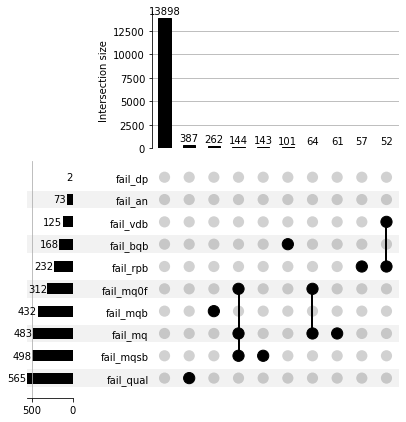

In [77]:
fail = info[[c for c in info.columns if 'fail_' in c]]
upset_format = from_indicators(fail.columns, fail)
UpSet(upset_format, min_subset_size=50, sort_by='cardinality', show_counts=True)

##### 1.4.1 Filter VCF using set cutoffs

Set path to QCed VCF

Use bcftools to filter and save to a new VCF

In [78]:
%%bash -s "$data_dir" "$logic" "$qced_ref"

data_dir=$1
logic=$2
qced_ref=$3

raw_ref="${data_dir}/GWD_30x_calls.vcf.gz"


original_ct=$( bcftools view -H -G ${raw_ref} | wc -l )

bcftools filter ${raw_ref} \
  -Oz \
  -i "${logic}" \
  -o ${qced_ref} \
&& filtered_ct=$( bcftools view -G -H ${qced_ref} | wc -l ) \
|| ( echo "Failed." && exit 1 )

if [ $? == 0 ]; then
    echo ">> Variant counts <<"
    echo -e "original $original_ct"
    echo -e "post-qc  $filtered_ct"
    echo -e "removed  $(( original_ct - filtered_ct ))"
fi

>> Variant counts <<
original 15683
post-qc  10976
removed  4707


## 2. Phase 1000G VCF

If needed, download genetic map from
https://storage.googleapis.com/broad-alkesgroup-public/Eagle/downloads/tables/genetic_map_hg38_withX.txt.gz

In [79]:
%%bash -s "$data_dir"

data_dir=$1

if [ ! -f "${data_dir}/genetic_map_hg38_withX.txt.gz" ]; then
    url="https://storage.googleapis.com/broad-alkesgroup-public/Eagle/downloads/tables/genetic_map_hg38_withX.txt.gz"
    wget ${url} \
      --directory-prefix ${data_dir} \
      --no-verbose
fi

Split multiallelic sites before running Eagle

In [84]:
%%bash -s "$qced_ref" "$split_ref"

qced_ref=$1
split_ref=$2

bcftools norm -m - ${qced_ref} \
  -Oz \
  -o ${split_ref}

Lines   total/split/realigned/skipped:	10976/55/0/0


In [91]:
%%bash -s "$data_dir" "$split_ref" "$phased_ref_prefix"

data_dir=$1
split_ref=$2
phased_ref_prefix=$3

echo $3

geneticMapFile="${data_dir}/genetic_map_hg38_withX.txt.gz"

eagle \
  --geneticMapFile ${geneticMapFile} \
  --vcf ${split_ref} \
  --numThreads 5 \
  --outPrefix ${phased_ref_prefix}
  

/home/jovyan/data/GWD_30x_calls.phased
                      +-----------------------------+
                      |                             |
                      |   Eagle v2.3.5              |
                      |   August 2, 2017            |
                      |   Po-Ru Loh                 |
                      |                             |
                      +-----------------------------+

Copyright (C) 2015-2016 Harvard University.
Distributed under the GNU GPLv3+ open source license.

Command line options:

eagle \
    --geneticMapFile /home/jovyan/data/genetic_map_hg38_withX.txt.gz \
    --vcf /home/jovyan/data/GWD_30x_calls.split.vcf.gz \
    --numThreads 5 \
    --outPrefix /home/jovyan/data/GWD_30x_calls.phased 

Setting number of threads to 5

=== Reading genotype data ===

Reading genotypes for N = 164 samples
Read M = 11031 variants
Filling in genetic map coordinates using reference file:
  /home/jovyan/data/genetic_map_hg38_withX.txt.gz
Physical dista

Check genotypes (first 20 variants in first 3 samples) to see how phasing changes VCFs

In [110]:
!bcftools view -H /home/jovyan/data/GWD_30x_calls.qced.vcf.gz | head -20 | cut -f 10-12

1/1:255,111,0	1/1:255,108,0	1/1:255,105,0
0/0:0,99,255	0/0:0,102,255	0/0:0,111,255
0/0:0,108,255	0/0:0,117,255	0/0:0,102,255
0/0:0,102,255	0/0:0,99,255	0/0:0,96,255
0/0:0,114,255	0/0:0,87,255	0/0:0,111,255
0/0:0,120,255	0/0:0,99,255	0/0:0,93,255
0/0:0,120,255	0/1:181,0,250	0/0:0,117,255
0/0:0,75,255	0/0:0,123,255	0/0:0,120,255
0/0:0,93,255	0/0:0,108,255	0/0:0,141,255
0/0:0,84,255	0/0:0,93,255	0/0:0,102,255
0/0:0,114,255	0/1:219,0,239	0/0:0,111,255
0/1:254,0,203	0/0:0,154,255	0/0:0,111,255
0/0:0,108,255	0/0:0,151,255	0/0:0,111,255
1/1:255,81,0	0/1:243,0,183	1/1:255,102,0
1/1:255,99,0	0/0:0,138,255	0/1:255,0,221
0/0:0,105,255	0/0:0,141,255	0/0:0,141,255
0/0:0,96,255	0/0:0,111,255	0/0:0,105,255
0/0:0,87,255	0/0:0,111,255	0/0:0,111,255
0/0:0,84,255	0/1:255,0,187	0/0:0,114,255
1/1:255,99,0	0/1:158,0,255	1/1:255,126,0
[main_vcfview] Error: cannot write to (null)


In [109]:
!bcftools view -H /home/jovyan/data/GWD_30x_calls.qced.phased.vcf.gz | head -20 | cut -f 10-12


1|1:255,111,0	1|1:255,108,0	1|1:255,105,0
0|0:0,99,255	0|0:0,102,255	0|0:0,111,255
0|0:0,108,255	0|0:0,117,255	0|0:0,102,255
0|0:0,102,255	0|0:0,99,255	0|0:0,96,255
0|0:0,114,255	0|0:0,87,255	0|0:0,111,255
0|0:0,120,255	0|0:0,99,255	0|0:0,93,255
0|0:0,120,255	1|0:181,0,250	0|0:0,117,255
0|0:0,75,255	0|0:0,123,255	0|0:0,120,255
0|0:0,93,255	0|0:0,108,255	0|0:0,141,255
0|0:0,84,255	0|0:0,93,255	0|0:0,102,255
0|0:0,114,255	1|0:219,0,239	0|0:0,111,255
1|0:254,0,203	0|0:0,154,255	0|0:0,111,255
0|0:0,108,255	0|0:0,151,255	0|0:0,111,255
1|1:255,81,0	0|1:243,0,183	1|1:255,102,0
1|1:255,99,0	0|0:0,138,255	1|0:255,0,221
0|0:0,105,255	0|0:0,141,255	0|0:0,141,255
0|0:0,96,255	0|0:0,111,255	0|0:0,105,255
0|0:0,87,255	0|0:0,111,255	0|0:0,111,255
0|0:0,84,255	1|0:255,0,187	0|0:0,114,255
1|1:255,99,0	0|1:158,0,255	1|1:255,126,0
[main_vcfview] Error: cannot write to (null)


## 3. QC GGVP VCF

Set up paths

In [131]:
ggvp_prefix = 'GGVP-illumina_omni2.5M'
raw_target=f'{data_dir}/{ggvp_prefix}.vcf.gz' 
qced_target=f'{data_dir}/{ggvp_prefix}.qced.vcf.gz'

# TODO: Split the QCed VCF and point to it
# Currently points to QCed target
split_target=qced_target

phased_target_prefix=f'{data_dir}/{ggvp_prefix}.phased'
phased_target=f'{phased_target_prefix}.vcf.gz'

imputed_target_prefix=f'{data_dir}/{ggvp_prefix}.imputed'
imputed_target=f'{data_dir}/{imputed_target_prefix}.vcf.gz'

In [137]:
%%bash -s "$raw_target" "$qced_target"

raw_target=$1
qced_target=$2


bcftools view ${raw_target} | grep "^##contig=<ID=19, "

##contig=<ID=19,length=58617616,assembly=GRCh38_full_analysis_set_plus_decoy_hla.fa>
##contig=<ID=19_GL000209v2_alt,length=177381,assembly=GRCh38_full_analysis_set_plus_decoy_hla.fa>
##contig=<ID=19_GL383573v1_alt,length=385657,assembly=GRCh38_full_analysis_set_plus_decoy_hla.fa>
##contig=<ID=19_GL383574v1_alt,length=155864,assembly=GRCh38_full_analysis_set_plus_decoy_hla.fa>
##contig=<ID=19_GL383575v2_alt,length=170222,assembly=GRCh38_full_analysis_set_plus_decoy_hla.fa>
##contig=<ID=19_GL383576v1_alt,length=188024,assembly=GRCh38_full_analysis_set_plus_decoy_hla.fa>
##contig=<ID=19_GL949746v1_alt,length=987716,assembly=GRCh38_full_analysis_set_plus_decoy_hla.fa>
##contig=<ID=19_GL949747v2_alt,length=729520,assembly=GRCh38_full_analysis_set_plus_decoy_hla.fa>
##contig=<ID=19_GL949748v2_alt,length=1064304,assembly=GRCh38_full_analysis_set_plus_decoy_hla.fa>
##contig=<ID=19_GL949749v2_alt,length=1091841,assembly=GRCh38_full_analysis_set_plus_decoy_hla.fa>
##contig=<ID=19_GL949750v2_alt,

In [159]:
%%bash -s "$raw_target" "$qced_target"

raw_target=$1
qced_target=$2


bcftools view ${raw_target} | sed 's/^19/chr19/g' | sed 's/##contig=<ID=19,/##contig=<ID=chr19,/g' | gzip > ${qced_target}

## 4. Phase GGVP VCF

In [160]:
%%bash -s "$data_dir" "$qced_target" "$phased_target_prefix"

data_dir=$1
qced_target=$2
phased_target_prefix=$3

genetic_map="${data_dir}/genetic_map_hg38_withX.txt.gz"

eagle \
  --geneticMapFile ${genetic_map} \
  --vcf ${qced_target} \
  --numThreads 5 \
  --outPrefix ${phased_target_prefix} 
  

                      +-----------------------------+
                      |                             |
                      |   Eagle v2.3.5              |
                      |   August 2, 2017            |
                      |   Po-Ru Loh                 |
                      |                             |
                      +-----------------------------+

Copyright (C) 2015-2016 Harvard University.
Distributed under the GNU GPLv3+ open source license.

Command line options:

eagle \
    --geneticMapFile /home/jovyan/data/genetic_map_hg38_withX.txt.gz \
    --vcf /home/jovyan/data/GGVP-illumina_omni2.5M.qced.vcf.gz \
    --numThreads 5 \
    --outPrefix /home/jovyan/data/GGVP-illumina_omni2.5M.phased 

Setting number of threads to 5

=== Reading genotype data ===

Reading genotypes for N = 407 samples
Read M = 1022 variants
Filling in genetic map coordinates using reference file:
  /home/jovyan/data/genetic_map_hg38_withX.txt.gz
Physical distance range: 1105398 base

Time for phasing batch: 0.323738

BATCH 2 OF 10

Phasing samples 41-81
Time for phasing batch: 0.303641

BATCH 3 OF 10

Phasing samples 82-122
Time for phasing batch: 0.29058

BATCH 4 OF 10

Phasing samples 123-162
Time for phasing batch: 0.252123

BATCH 5 OF 10

Phasing samples 163-203
Time for phasing batch: 0.239076

BATCH 6 OF 10

Phasing samples 204-244
Time for phasing batch: 0.253954

BATCH 7 OF 10

Phasing samples 245-284
Time for phasing batch: 0.252948

BATCH 8 OF 10

Phasing samples 285-325
Time for phasing batch: 0.249691

BATCH 9 OF 10

Phasing samples 326-366
Time for phasing batch: 0.269964

BATCH 10 OF 10

Phasing samples 367-407
Time for phasing batch: 0.228298

Time for PBWT iter 1: 2.66405

BEGINNING PBWT ITER 2

BATCH 1 OF 10

Phasing samples 1-40


Time for phasing batch: 0.325832

BATCH 2 OF 10

Phasing samples 41-81
Time for phasing batch: 0.315772

BATCH 3 OF 10

Phasing samples 82-122
Time for phasing batch: 0.301271

BATCH 4 OF 10

Phasing samples 123-162
Time for phasing batch: 0.261671

BATCH 5 OF 10

Phasing samples 163-203
Time for phasing batch: 0.275043

BATCH 6 OF 10

Phasing samples 204-244
Time for phasing batch: 0.287336

BATCH 7 OF 10

Phasing samples 245-284
Time for phasing batch: 0.285864

BATCH 8 OF 10

Phasing samples 285-325
Time for phasing batch: 0.277348

BATCH 9 OF 10

Phasing samples 326-366
Time for phasing batch: 0.304671

BATCH 10 OF 10

Phasing samples 367-407
Time for phasing batch: 0.291709

Time for PBWT iter 2: 2.92657
Writing vcf.gz output to /home/jovyan/data/GGVP-illumina_omni2.5M.phased.vcf.gz
Time for writing output: 0.896967
Total elapsed time for analysis = 12.7974 sec


## 5. Impute GGVP VCF

Process reference haplotypes into M3VCF format

In [ ]:
%%bash -s "$phased_ref" "$phased_ref_prefix"

phased_ref=$1
phased_ref_prefix=$2

# NOTE: We need to manually specify "chr19" because Minimac doesn't like 
# the "chr" prefix in front of GRCh38 chromosomes
./bin/Minimac3 \
  --refHaps ${phased_ref} \
  --processReference \
  --prefix ${phased_ref_prefix} \
  --chr "chr19"

In [164]:
%%bash -s "$data_dir" "$phased_ref_prefix" "$phased_target" "$imputed_target_prefix"

data_dir=$1
phased_ref_prefix=$2
phased_target=$3
imputed_target_prefix=$4

genetic_map="${data_dir}/genetic_map_hg38_withX.txt.gz"

minimac4 \
  --refHaps "${phased_ref_prefix}.m3vcf.gz" \
  --mapFile ${genetic_map} \
  --haps ${phased_target} \
  --ignoreDuplicates \
  --format GT \
  --prefix ${imputed_target_prefix}
  



 -------------------------------------------------------------------------------- 
          Minimac4 - Fast Imputation Based on State Space Reduction HMM
 --------------------------------------------------------------------------------
           (c) 2014 - Sayantan Das, Christian Fuchsberger, David Hinds
                             Mary Kate Wing, Goncalo Abecasis 

 Version: 1.0.3;
 Built: Thu 16 Jun 2022 08:18:21 AM UTC by root

 Command Line Options: 
       Reference Haplotypes : --refHaps [/home/jovyan/data/GWD_30x_calls.phased.m3vcf.gz],
                              --passOnly, --rsid, --referenceEstimates [ON],
                              --mapFile [/home/jovyan/data/genetic_map_hg38_withX.txt.gz]
          Target Haplotypes : --haps [/home/jovyan/data/GGVP-illumina_omni2.5M.phased.vcf.gz]
          Output Parameters : --prefix [/home/jovyan/data/GGVP-illumina_omni2.5M.imputed],
                              --estimate, --nobgzip, --vcfBuffer [200],
                     

In [167]:
%%bash -s "$phased_target" "$imputed_target_prefix"

phased_target=$1
imputed_target_prefix=$2

bcftools view -H "${imputed_target_prefix}.dose.vcf.gz" | wc -l

11031


In [172]:
%%bash -s "$phased_target" "$imputed_target_prefix"

phased_target=$1
imputed_target_prefix=$2

bcftools view -H -i 'POS=48703417' "${imputed_target_prefix}.dose.vcf.gz" 

chr19	48703417	chr19:48703417:G:A	G	A	.	PASS	AF=0.53393;MAF=0.46607;R2=0.99812;IMPUTED	GT	0|0	1|0	0|1	1|1	0|1	1|0	0|0	1|1	0|0	0|1	0|1	0|1	0|1	1|0	0|0	1|1	1|1	1|0	1|0	1|1	0|0	0|0	0|1	1|1	0|0	0|1	0|0	1|1	0|0	1|0	0|0	1|1	1|0	0|1	0|0	1|1	0|1	1|1	1|1	0|0	0|1	0|0	0|1	1|0	1|0	1|1	0|0	0|0	1|0	0|1	0|0	0|0	0|1	0|0	0|1	1|0	0|1	1|1	1|0	1|1	1|1	1|0	1|1	0|0	0|1	0|1	0|0	1|0	1|1	1|0	0|0	1|0	0|1	0|1	1|1	0|1	1|1	0|0	0|1	0|0	1|0	0|1	1|0	1|1	0|0	1|0	1|0	0|1	1|0	1|1	1|0	0|0	1|0	0|1	0|0	1|1	1|1	1|0	1|0	1|0	0|1	1|1	1|1	1|0	0|0	0|1	0|1	0|0	1|1	0|0	1|1	1|1	0|0	0|1	1|0	0|1	1|0	1|1	1|1	0|1	1|0	1|0	1|1	1|1	1|1	1|1	1|0	0|0	1|0	0|1	1|0	1|0	1|0	0|1	1|1	0|1	1|1	0|1	0|1	0|0	0|1	1|0	0|0	1|0	1|1	0|0	1|1	0|0	1|0	1|1	0|1	1|0	0|1	1|1	0|1	0|0	0|1	1|0	0|1	0|0	1|1	1|0	0|0	1|0	1|0	1|0	1|1	1|1	1|0	1|1	1|0	1|1	1|1	0|1	1|1	1|0	1|0	1|0	1|1	1|1	0|0	0|1	1|0	0|1	1|1	0|1	1|1	1|1	0|1	0|0	0|0	0|0	1|1	0|1	0|0	1|1	1|1	1|0	1|0	1|1	0|1	0|1	1|1	1|0	1|0	1|1	1|1	1|0	0|0	0|0	1|0	1|0	0|1	1|1	0|1	1|0	1|1	1|0	1|1	0|0	1|1	0|0	1|1	1|1	1|0	0|0	1|1	1|

In [175]:
%%bash -s "$raw_target"

raw_target=$1


bcftools view -H -i 'POS=48703417' "${raw_target}" 